In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost                       #For training an extreme gradient boosting model on data
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures  #For standardizing/tranforming numeric variables
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV  #For performing model cross-validation
from sklearn.metrics import log_loss, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,\
    recall_score, f1_score, fbeta_score, precision_recall_curve, roc_curve, roc_auc_score, auc, make_scorer  #For evaluating classifier model


pd.set_option('display.max_columns', None)

In [12]:
# loading csv, choosing variables, checking for null values

df = pd.read_csv('../../data/census_epa_theil_cleaned.csv')
df = df[[
    'pct_pop_white_only',
    'pct_pop_black',
    'pct_pop_asian',
    'pct_pop_hispanic_latino_any',
    'pop_density',
    'prim_ind_share',
    'sec_ind_share',
    'poverty_pct',
    'theil_income_median',
    'health_ins_pct',
    'PM25',
    'OZONE',
    'DSLPM',
    'PTRAF',
    'PRE1960PCT',
    'PNPL',
    'PRMP',
    'PTSDF',
    'UST',
    'PWDIS'
]]

print(df.isnull().sum())

pct_pop_white_only             0
pct_pop_black                  0
pct_pop_asian                  0
pct_pop_hispanic_latino_any    0
pop_density                    0
prim_ind_share                 0
sec_ind_share                  0
poverty_pct                    0
theil_income_median            0
health_ins_pct                 0
PM25                           0
OZONE                          0
DSLPM                          0
PTRAF                          0
PRE1960PCT                     0
PNPL                           0
PRMP                           0
PTSDF                          0
UST                            0
PWDIS                          0
dtype: int64


In [13]:
# setting PM25_high as target binary variable, making urban cutoff, and checking for class balance

df['PM25_high'] = np.where(df['PM25'] > 9, 1 ,0)
df = df[df['pop_density'] > 500]

print(len(df[df['PM25_high']==1])/len(df))

0.3383888203863543


In [14]:
# separating independent and dependent variables

y = df['PM25_high']
X = df.drop(['PM25', 'PM25_high'], axis=1)

In [15]:
# 68/12/20 train-val-test split with stratification and seed=201

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=201, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=201, stratify=y_train_val)

print("Original high percent: " + str(y.sum()/len(y)))
print("Train high percent: " + str(y_train.sum()/len(y_train)))
print("Val high percent: " + str(y_val.sum()/len(y_val)))
print("Test high percent: " + str(y_test.sum()/len(y_test)))
print("The train/val/test split percent is: " + str(len(y_train)/len(y)*100) + " / " + str(len(y_val)/len(y)*100) + " / " + str(len(y_test)/len(y)*100))

Original high percent: 0.3383888203863543
Train high percent: 0.33840062862669246
Val high percent: 0.33835616438356164
Test high percent: 0.33836826962597616
The train/val/test split percent is: 67.99835593916976 / 12.00164406083025 / 20.0


In [16]:
# scaling our data-- minmax scaler for everything
# fit on just the training set to minimize leakage

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [17]:
# defining the f2 metric (since there isn't one built-in, it's a common special case of fbeta metric)
# Note: this is the negative since xgboost minimizes its objective function

def f2_eval(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)

    f2 = fbeta_score(y_true, y_pred_binary, beta=2)
    
    return 'f2_score', -f2


In [18]:
# making the xgboost model and training it to make sure everything's set up properly
# objective = binary:logistic is standard
# missing = -999 because we don't have any missing data
# seed = 201 is random, just using 201 for all random seeds
# scale_pos_weight is the standard recommendation: scale_pos_weight = low-risk/high-risk = 0.66/0.33 = 2
# learning_rate=0.3 to start out high and make hyperparameter tuning faster
# we'll tune the other hyperparameters below

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3)
xgb_clf = xgb_clf.fit(
    X_train,
    y_train,
    verbose=True,
    eval_metric = f2_eval,
    eval_set = [(X_val, y_val)],
    early_stopping_rounds = 20
)


[0]	validation_0-logloss:0.61325	validation_0-f2_score:-0.71346
[1]	validation_0-logloss:0.56383	validation_0-f2_score:-0.77288
[2]	validation_0-logloss:0.52977	validation_0-f2_score:-0.77803
[3]	validation_0-logloss:0.50451	validation_0-f2_score:-0.78522
[4]	validation_0-logloss:0.48669	validation_0-f2_score:-0.79432
[5]	validation_0-logloss:0.46687	validation_0-f2_score:-0.79654
[6]	validation_0-logloss:0.45320	validation_0-f2_score:-0.79983
[7]	validation_0-logloss:0.44239	validation_0-f2_score:-0.79971
[8]	validation_0-logloss:0.43183	validation_0-f2_score:-0.80235
[9]	validation_0-logloss:0.42179	validation_0-f2_score:-0.80690
[10]	validation_0-logloss:0.41066	validation_0-f2_score:-0.81555
[11]	validation_0-logloss:0.40381	validation_0-f2_score:-0.81802
[12]	validation_0-logloss:0.40032	validation_0-f2_score:-0.82194


c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.39576	validation_0-f2_score:-0.82090
[14]	validation_0-logloss:0.38530	validation_0-f2_score:-0.82440
[15]	validation_0-logloss:0.38217	validation_0-f2_score:-0.82786
[16]	validation_0-logloss:0.38077	validation_0-f2_score:-0.82826
[17]	validation_0-logloss:0.37666	validation_0-f2_score:-0.83035
[18]	validation_0-logloss:0.37160	validation_0-f2_score:-0.83511
[19]	validation_0-logloss:0.36487	validation_0-f2_score:-0.83495
[20]	validation_0-logloss:0.36003	validation_0-f2_score:-0.83771
[21]	validation_0-logloss:0.35688	validation_0-f2_score:-0.83293
[22]	validation_0-logloss:0.35359	validation_0-f2_score:-0.83747
[23]	validation_0-logloss:0.35072	validation_0-f2_score:-0.83544
[24]	validation_0-logloss:0.34676	validation_0-f2_score:-0.83974
[25]	validation_0-logloss:0.34605	validation_0-f2_score:-0.83941
[26]	validation_0-logloss:0.34480	validation_0-f2_score:-0.84152
[27]	validation_0-logloss:0.34123	validation_0-f2_score:-0.84056
[28]	validation_0-logloss

c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is dep

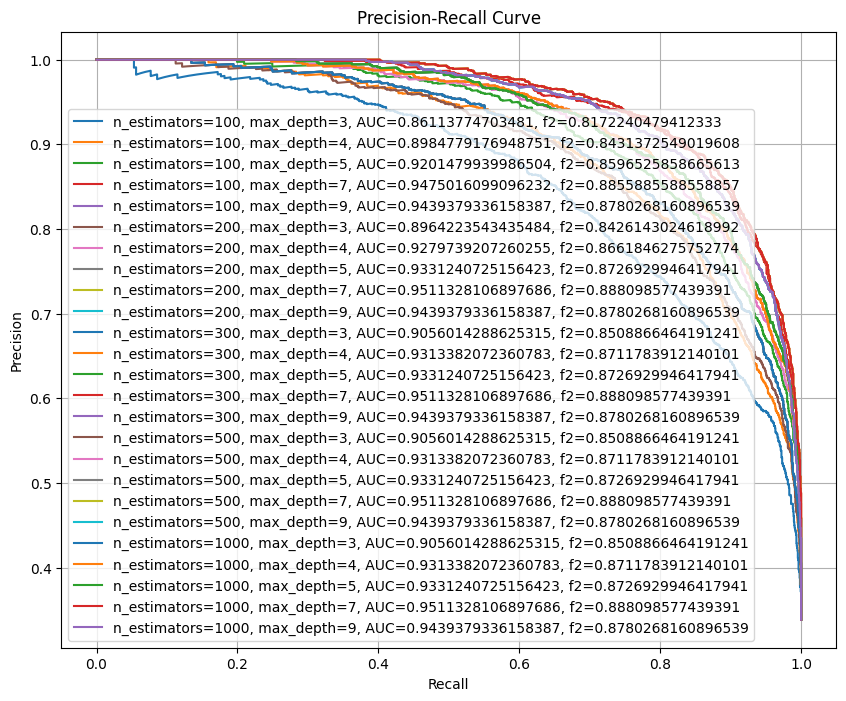

In [9]:
# we'll use this for loop before gridsearchCV to find best values of n_estimators and max_depth while minimizing overfitting risk
# this code plots the PR curves for all the values of n_estimators and max_depth below
# then, we'll take the lowest values that give the best f2 and AUC-PR
# looks like the best one is (200,7)

n_estimators_values = [100,200,300,500,1000]
max_depth_values = [3,4,5,7,9]

plt.figure(figsize=(10,8))

for n in n_estimators_values:
    for m in max_depth_values:
        xgb_clf_nm = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, n_estimators=n, max_depth=m)
        xgb_clf_nm = xgb_clf_nm.fit(
            X_train,
            y_train,
            verbose=False,
            eval_metric = f2_eval,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 20,
        )
        y_prob = xgb_clf_nm.predict_proba(X_val)[:,1]
        precision, recall, _ = precision_recall_curve(y_val, y_prob)
        auc_score = auc(recall, precision)
        
        y_pred = xgb_clf_nm.predict(X_val)
        f2 = fbeta_score(y_val, y_pred, beta=2)

        plt.plot(recall, precision, label = f'n_estimators={n}, max_depth={m}, AUC={auc_score}, f2={f2}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# gridsearchCV to help tune hyperparameters
# for our first grid search, we'll try some regularization to see if we can increase n_estimators and max_depth
# looks like we should try increasing n_estimators and max_depth with reg_lambda=10

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3)

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'n_estimators' : [200,300],
    'max_depth' : [7,9],
    'min_child_weight' : [1,2,3],
    'colsample_bytree' : [0.8,0.9,1],
    'reg_lambda' : [0,1,10]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'colsample_bytree': 1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 300, 'reg_lambda': 10}
Best f2:  0.8780876188109069


c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is dep

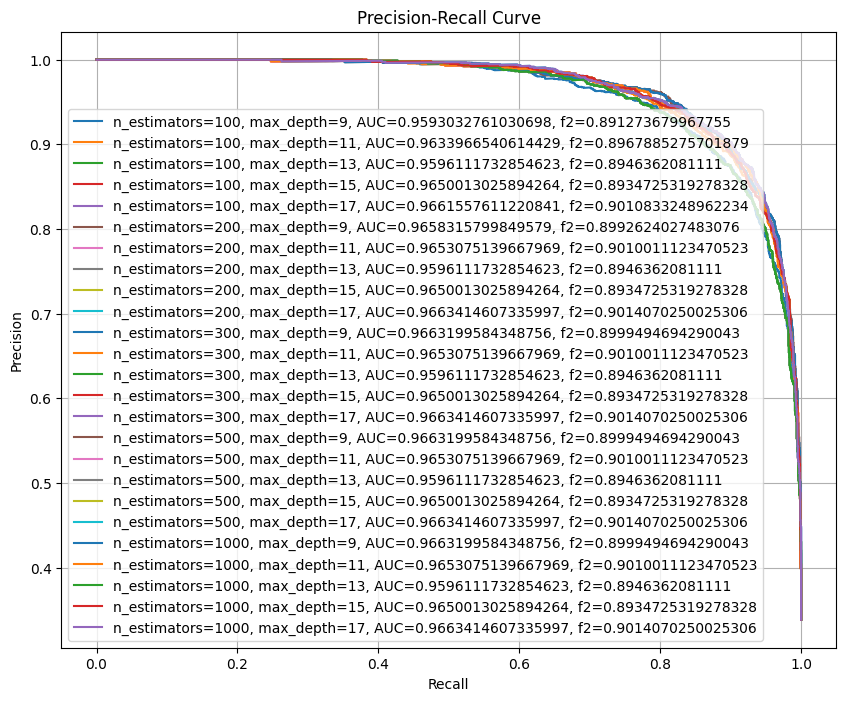

In [14]:
# now that we have some regularization, let's see how far we can increase max_depth and n_estimators
# looks like (200,17) is the best, but that's pretty high, so we'll examine further in gridsearch

n_estimators_values = [100,200,300,500,1000]
max_depth_values = [9,11,13,15,17]

plt.figure(figsize=(10,8))

for n in n_estimators_values:
    for m in max_depth_values:
        xgb_clf_nm = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, reg_lambda=10, n_estimators=n, max_depth=m)
        xgb_clf_nm = xgb_clf_nm.fit(
            X_train,
            y_train,
            verbose=False,
            eval_metric = f2_eval,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 20,
        )
        y_prob = xgb_clf_nm.predict_proba(X_val)[:,1]
        precision, recall, _ = precision_recall_curve(y_val, y_prob)
        auc_score = auc(recall, precision)
        
        y_pred = xgb_clf_nm.predict(X_val)
        f2 = fbeta_score(y_val, y_pred, beta=2)

        plt.plot(recall, precision, label = f'n_estimators={n}, max_depth={m}, AUC={auc_score}, f2={f2}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# we got (n_estimators, max_depth) = (200,17) from our loop above, but that seems high
# so let's try different regularization parameters and see if they help
# warning: this is a big grid search, so it will take a LONG time
# min_child_weight and subsample didn't end up matering, and n_estimators was fine at 200 or 300 so you can set those and get rid of them from the grid to speed up the search if you want to check this on your own
# looks like (300,13) is best, with colsamply_bytree=0.9 and reg_alpha=0.1, and subsample and min_child_weight didn't matter (so just leave their defaults)

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, max_depth=17, reg_lambda=10)

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'max_depth' : [9,13,17],
    'n_estimators' : [100,200,300],
    'subsample' : [0.8,0.9,1],
    'colsample_bytree' : [0.8,0.9,1],
    'min_child_weight' : [1,2,3],
    'reg_alpha' : [0,0.01,0.1]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Hyperparameters: {'colsample_bytree': 0.9, 'max_depth': 13, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.1, 'subsample': 1}
Best f2:  0.8819404890656785


c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Braeden\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is dep

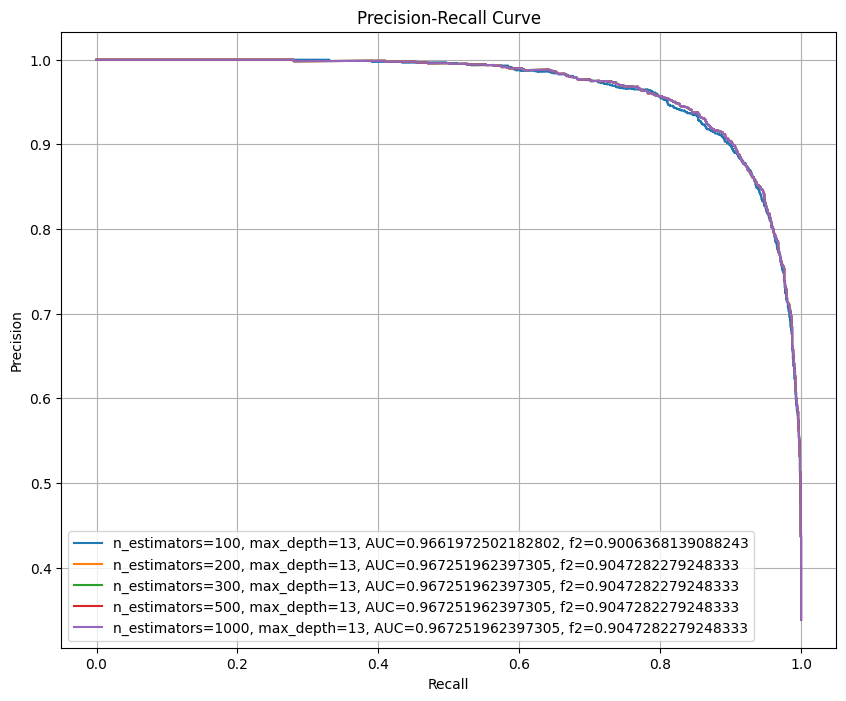

In [27]:
# let's just make sure the n_estimators=300 from gridsearch isn't superficial
# looks like n_estimators=100 is low, but 200 is just as good as anything higher
# we'll stick with 200

n_estimators_values = [100,200,300,500,1000]

plt.figure(figsize=(10,8))

for n in n_estimators_values:
    xgb_clf_nm = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, learning_rate=0.3, max_depth=13, reg_lambda=10, reg_alpha=0.1, colsample_bytree=0.9, n_estimators=n)
    xgb_clf_nm = xgb_clf_nm.fit(
        X_train,
        y_train,
        verbose=False,
        eval_metric = f2_eval,
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 20,
    )
    y_prob = xgb_clf_nm.predict_proba(X_val)[:,1]
    precision, recall, _ = precision_recall_curve(y_val, y_prob)
    auc_score = auc(recall, precision)
        
    y_pred = xgb_clf_nm.predict(X_val)
    f2 = fbeta_score(y_val, y_pred, beta=2)

    plt.plot(recall, precision, label = f'n_estimators={n}, max_depth={13}, AUC={auc_score}, f2={f2}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# finally, let's tune the learning rate
# looks like learning_rate=0.1 is best

xgb_clf = xgboost.XGBClassifier(objective='binary:logistic', missing=-999, seed=201, scale_pos_weight=2, n_estimators=200, max_depth=13, colsample_bytree=0.9, reg_lambda=10, reg_alpha=0.1)

f2_scorer = make_scorer(fbeta_score, beta=2)
param_grid = {
    'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring=f2_scorer, cv=5, verbose=1, n_jobs=1)

grid_search.fit(X_train,y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best f2: ", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'learning_rate': 0.1}
Best f2:  0.8821894494134137


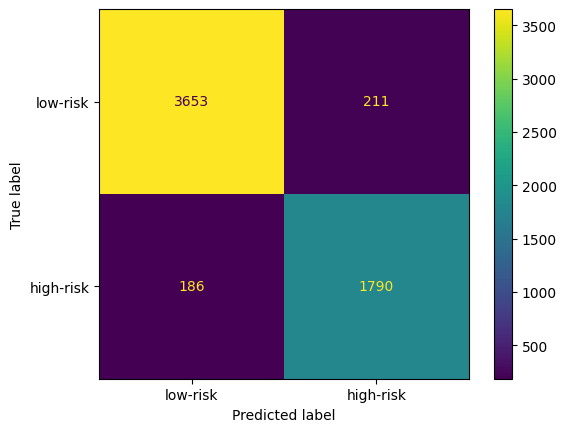

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.9320205479452055 | baseline: 0.33835616438356164
precision: 0.894552723638181 | baseline: 0.33835616438356164
recall: 0.9058704453441295 | baseline: 1
f1 score: 0.9001760120693991 | baseline: 0.5056294779938588
f2 score: 0.9035840484603735 | baseline: 0.7188591385331781
AUC-PR: 0.9670848309093746 | baseline: 0.33835616438356164


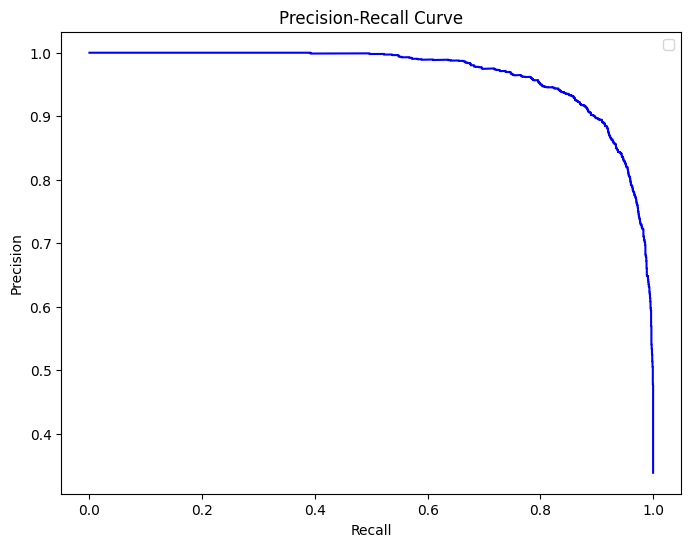

In [20]:
# evaluating all the metrics we want on the val data
# baseline = label everything high-risk

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
y_prob = best_model.predict_proba(X_val)[:,1]

high_pct = y_val.sum()/len(y_val)
cm = confusion_matrix(y_val, y_pred)
precision, recall, _ = precision_recall_curve(y_val, y_prob)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low-risk", "high-risk"])
disp.plot()
plt.show()

print("accuracy: " + str(accuracy_score(y_val, y_pred)) + " | baseline: " + str(high_pct))
print("precision: " + str(precision_score(y_val, y_pred)) + " | baseline: " + str(high_pct))
print("recall: " + str(recall_score(y_val, y_pred)) + " | baseline: " + str(1))
print("f1 score: " + str(fbeta_score(y_val, y_pred, beta=1)) + " | baseline: " + str(2*high_pct/(high_pct+1)))
print("f2 score: " + str(fbeta_score(y_val, y_pred, beta=2)) + " | baseline: " + str(5*high_pct/(4*high_pct+1)))
print("AUC-PR: " + str(auc(recall, precision)) + " | baseline: " + str(high_pct))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

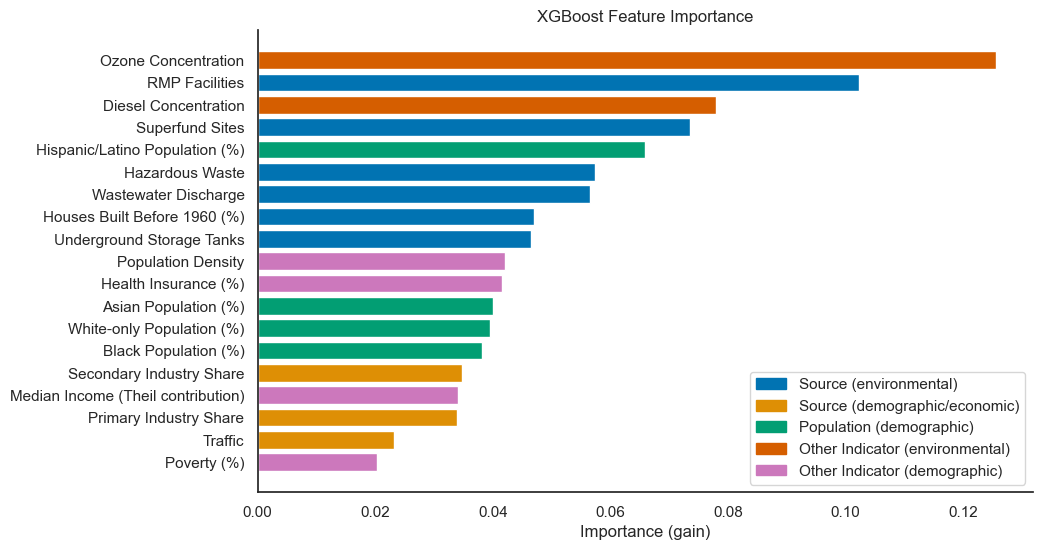

In [21]:
# computing feature importance to see what variables our model thinks are important

# setting style, colors, and labels via dicts to make the plot more readable
sns.set(style="white")

df_features = df.drop(['PM25', 'PM25_high'], axis=1)

df_columns = df_features.columns.tolist()
feature_importance = best_model.feature_importances_

colors = sns.color_palette("colorblind", n_colors=5)

color_dict = {
    'Source (environmental)' : colors[0],
    'Source (demographic/economic)' : colors[1],
    'Population (demographic)' : colors[2],
    'Other Indicator (environmental)' : colors[3],
    'Other Indicator (demographic)' : colors[4],
}

feature_group_dict = {
    'pct_pop_white_only' : 'Population (demographic)',
    'pct_pop_black' : 'Population (demographic)',
    'pct_pop_asian' : 'Population (demographic)',
    'pct_pop_hispanic_latino_any' : 'Population (demographic)',
    'pop_density' : 'Other Indicator (demographic)',
    'prim_ind_share' : 'Source (demographic/economic)',
    'sec_ind_share' : 'Source (demographic/economic)',
    'poverty_pct' : 'Other Indicator (demographic)',
    'theil_income_median' : 'Other Indicator (demographic)',
    'health_ins_pct' : 'Other Indicator (demographic)',
    'OZONE' : 'Other Indicator (environmental)',
    'DSLPM' : 'Other Indicator (environmental)',
    'PTRAF' : 'Source (demographic/economic)',
    'PRE1960PCT' : 'Source (environmental)',
    'PNPL' : 'Source (environmental)',
    'PRMP' : 'Source (environmental)',
    'PTSDF' : 'Source (environmental)',
    'UST' : 'Source (environmental)',
    'PWDIS' : 'Source (environmental)'
}

label_dict ={
    'pct_pop_white_only' : 'White-only Population (%)',
    'pct_pop_black' : 'Black Population (%)',
    'pct_pop_asian' : 'Asian Population (%)',
    'pct_pop_hispanic_latino_any' : 'Hispanic/Latino Population (%)',
    'pop_density' : 'Population Density',
    'prim_ind_share' : 'Primary Industry Share',
    'sec_ind_share' : 'Secondary Industry Share',
    'poverty_pct' : 'Poverty (%)',
    'theil_income_median' : 'Median Income (Theil contribution)',
    'health_ins_pct' : 'Health Insurance (%)',
    'OZONE' : 'Ozone Concentration',
    'DSLPM' : 'Diesel Concentration',
    'PTRAF' : 'Traffic',
    'PRE1960PCT' : 'Houses Built Before 1960 (%)',
    'PNPL' : 'Superfund Sites',
    'PRMP' : 'RMP Facilities',
    'PTSDF' : 'Hazardous Waste',
    'UST' : 'Underground Storage Tanks',
    'PWDIS' : 'Wastewater Discharge'
}

# sorting the features
df_features = df.drop(['PM25', 'PM25_high'], axis=1)

df_columns = df_features.columns.tolist()
feature_importance = best_model.feature_importances_

importance_indices_sorted = np.argsort(feature_importance)

df_columns_sorted = [df_columns[i] for i in importance_indices_sorted]
feature_importance_sorted = feature_importance[importance_indices_sorted]

# plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(df_columns_sorted, feature_importance_sorted, color=[color_dict[feature_group_dict[col]] for col in df_columns_sorted])

plt.yticks(df_columns_sorted, [label_dict[col] for col in df_columns_sorted])

plt.xlabel('Importance (gain)')
plt.title('XGBoost Feature Importance')

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_dict[group]) for group in color_dict.keys()]
legend = plt.legend(legend_handles, color_dict.keys(), loc='lower right')
legend.get_title().set_fontsize(12)

sns.despine()
plt.show()

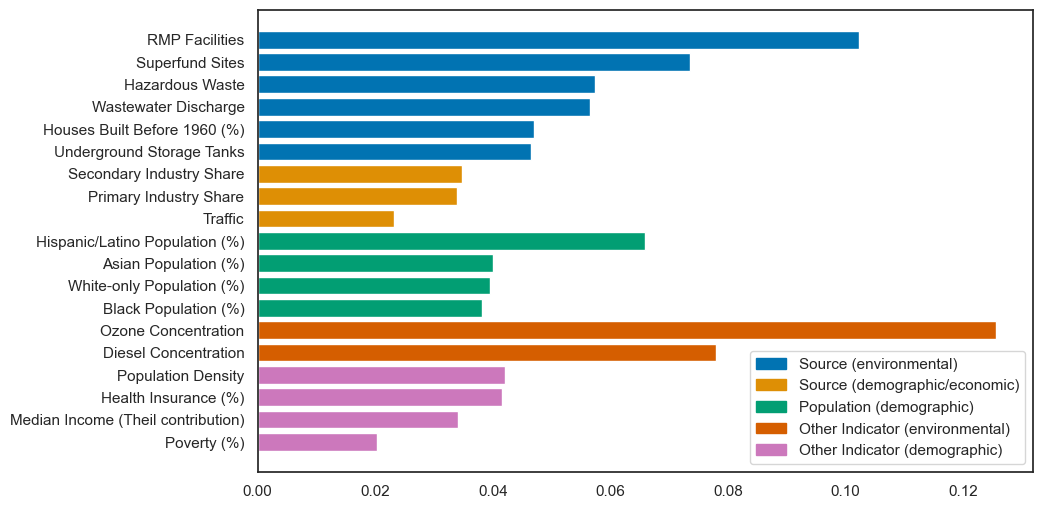

In [46]:
# sorting feature importance within each category and plotting

sorted_groups = sorted(color_dict.keys())

sorted_columns = []
for group in sorted_groups:
    group_features = [feature for feature, feature_group in feature_group_dict.items() if feature_group == group]
    group_indices = [df_columns.index(feature) for feature in group_features]
    group_sorted_indices = np.argsort([feature_importance[i] for i in group_indices])
    sorted_columns.extend([group_features[i] for i in group_sorted_indices])

plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_columns, [feature_importance[df_columns.index(col)] for col in sorted_columns],
               color=[color_dict[feature_group_dict[col]] for col in sorted_columns])

legend_labels = list(color_dict.keys())
legend_colors = list(color_dict.values())
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
plt.legend(legend_patches, legend_labels, loc='lower right')

plt.yticks(sorted_columns, [label_dict[col] for col in sorted_columns])
plt.show()

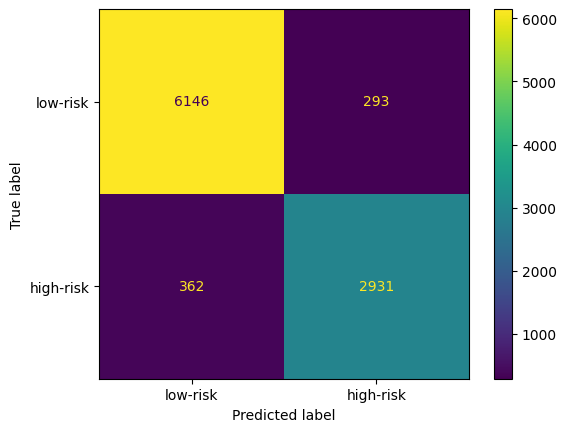

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.9326962597616112 | baseline: 0.33836826962597616
precision: 0.9091191066997518 | baseline: 0.33836826962597616
recall: 0.8900698451260249 | baseline: 1
f1 score: 0.8994936320392819 | baseline: 0.5056429942418426
f2 score: 0.8938155647718957 | baseline: 0.7188700663639539
AUC-PR: 0.9661845262368645 | baseline: 0.33836826962597616


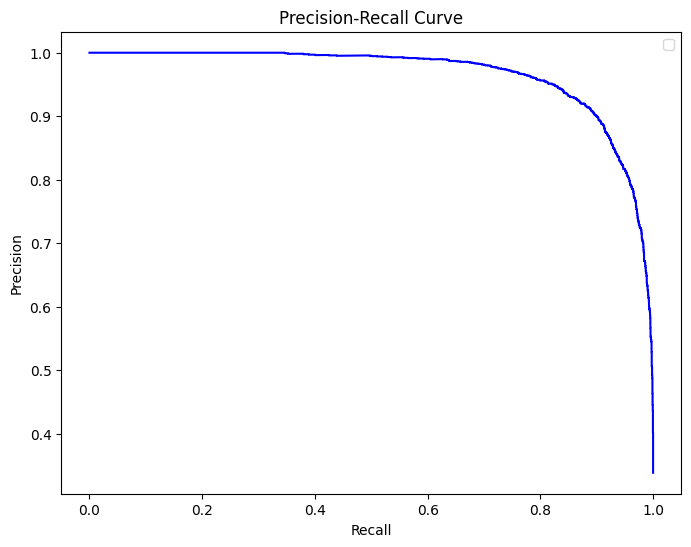

In [17]:
# evaluating all the metrics we want on the val data
# baseline = label everything high-risk

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

high_pct = y_test.sum()/len(y_test)
cm = confusion_matrix(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_prob)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low-risk", "high-risk"])
disp.plot()
plt.show()

print("accuracy: " + str(accuracy_score(y_test, y_pred)) + " | baseline: " + str(high_pct))
print("precision: " + str(precision_score(y_test, y_pred)) + " | baseline: " + str(high_pct))
print("recall: " + str(recall_score(y_test, y_pred)) + " | baseline: " + str(1))
print("f1 score: " + str(fbeta_score(y_test, y_pred, beta=1)) + " | baseline: " + str(2*high_pct/(high_pct+1)))
print("f2 score: " + str(fbeta_score(y_test, y_pred, beta=2)) + " | baseline: " + str(5*high_pct/(4*high_pct+1)))
print("AUC-PR: " + str(auc(recall, precision)) + " | baseline: " + str(high_pct))

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()